### T-SNE to visualize the fraud cases

t-SNE (t-Distributed Stochastic Neighbor Embedding) is nonlinear dimensionality reduction technique in which interrelated high dimensional data (usually hundreds or thousands of variables) is mapped into low-dimensional data (like 2 or 3 variables) while preserving the significant structure (relationship among the data points in different variables) of original high dimensional data.
Good Qand A are here:   
https://lvdmaaten.github.io/tsne/

There are five parameters that control the optimization of t-SNE and therefore possibly the quality of the resulting embedding:

- perplexity

- early exaggeration factor

- learning rate

- maximum number of iterations

- angle (not used in the exact method)


**default values for TSNE package are**
(n_components=2,
*, 
perplexity=30.0, 
early_exaggeration=12.0, 
learning_rate=200.0, 
n_iter=1000, 
n_iter_without_progress=300, 
min_grad_norm=1e-07, 
metric='euclidean', 
init='random', 
verbose=0, 
random_state=None, 
method='barnes_hut', 
angle=0.5, 
n_jobs=None)




In [2]:
# importing the packages
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
import sklearn.exceptions
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from imblearn.under_sampling import NearMiss 
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)


from numpy import asarray
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

## Data Preprocessing steps

In [3]:
data_train = pd.read_csv("fraudTrain.csv")
data_test = pd.read_csv("fraudTest.csv")
# taking smaller sample to run the model faster

df_train= data_train.sample(frac = 0.1,random_state=1)
df_test= data_test.sample(frac = 0.05,random_state=1)
print(df_train.shape,df_test.shape)

(129668, 23) (27786, 23)


In [4]:
def getdatafiles():
    # loading data
    data_train = pd.read_csv("fraudTrain.csv")
    data_test = pd.read_csv("fraudTest.csv")
    # taking smaller sample to run the model faster

    df_train= data_train.sample(frac = 0.1,random_state=1)
    df_test= data_test.sample(frac = 0.05,random_state=1)
    print(df_train.shape,df_test.shape)
    
    # function to drop tbe columns
    def dropCol(data):
        col_to_drop = ['trans_date_trans_time','Unnamed: 0',
                       'cc_num','first','last','trans_num','street',
                      'trans_date_trans_time','unix_time']
        res = data.drop(col_to_drop,axis = 1)
        return res
    # dropping the columns
    # dropping the columns ['trans_date_trans_time','Unnamed: 0','cc_num','first','last','trans_num']
    # train data set
    df_train = dropCol(df_train)
    # test data set
    df_test = dropCol(df_test)
    
    # creating a new feature address
    df_train['add'] = df_train['city'] + df_train['state'] + df_train['zip'].astype(str)
    df_test['add'] = df_test['city'] + df_test['state'] + df_test['zip'].astype(str)
    df_train = df_train.drop(['city','state','zip'],axis =1)
    df_test = df_test.drop(['city','state','zip'],axis =1)
    print ( df_train.shape, df_test.shape)
    

    #Create independent and Dependent Features
    columns = df_train.columns.tolist()

    # removing the dependent feature is_fraud
    columns = [c for c in columns if c not in ["is_fraud"]]

    X_train = df_train[columns]
    Y_train = df_train['is_fraud']
    X_test = df_test[columns]
    Y_test = df_test['is_fraud']
    print ( X_train.shape, Y_train.shape,X_test.shape, Y_test.shape)

    # function to convert dob to years
    def age_years(born):
        return 2019 - int(born[0:4])

    # replacing the dob column with age column in our data set for test and train
    X_train['age'] = X_train['dob'].apply(lambda x: age_years(x))
    X_train = X_train.drop(['dob'],axis =1)

    X_test['age'] = X_test['dob'].apply(lambda x: age_years(x))
    X_test = X_test.drop(['dob'],axis =1)
    
    print(X_train.shape,X_test.shape)

    # concanating the test and train data so that number of columns remain the same in both the data sets
    final_df = pd.concat([X_train,X_test],axis=0)
    final_df.shape


    # creating the list of categorical variables
    categorical_features =[feature for feature in X_train.columns if final_df[feature].dtypes == 'O']
    categorical_features
    
    # function to convert categorical variables to one hot encoding
    def category_onehot_multcols(data,multcolumns):
        df_final = data
        i=0
        for fields in multcolumns:
            print(fields)
            df1=pd.get_dummies(final_df[fields],drop_first=True)
            final_df.drop([fields],axis=1,inplace=True)
            if i==0:
                df_final=df1.copy()
            else:           
                df_final=pd.concat([df_final,df1],axis=1)
            i=i+1             
        df_final=pd.concat([final_df,df_final],axis=1)
        return df_final

    # applying the one hot encoding
    final_df = category_onehot_multcols(final_df, categorical_features)

    # removing duplicated columns
    final_df =final_df.loc[:,~final_df.columns.duplicated()]
    final_df.shape

    # separating the test and training data
    df_Train=final_df.iloc[:129668,:]
    df_Test=final_df.iloc[129668:,:]
    print(df_Train.shape,df_Test.shape)
    print(Y_train.value_counts(),"\n",Y_test.value_counts())
    
    # define standard scaler
    scaler = StandardScaler()
    # transform data
    df_Train = scaler.fit_transform(df_Train)
    df_Test = scaler.fit_transform(df_Test)# define standard scaler
    
    
    
    # files ready for testing on models
    print(df_Train.shape, df_Test.shape, Y_train.shape, Y_test.shape)
    return df_Train, df_Test, Y_train, Y_test


In [5]:
# function to evaluate our model 
def print_eval(y_pred,model):
    print("Training Accuracy: ",model.score(df_Train, Y_train))
    print("Testing Accuracy: ", model.score(df_Test, Y_test))
    print(confusion_matrix(Y_test, y_pred))
    
    print(classification_report(Y_test,y_pred))


In [6]:
df_Train, df_Test, Y_train, Y_test = getdatafiles()

(129668, 23) (27786, 23)
(129668, 13) (27786, 13)
(129668, 12) (129668,) (27786, 12) (27786,)
(129668, 12) (27786, 12)
merchant
category
gender
job
add
(129668, 2143) (27786, 2143)
0    128963
1       705
Name: is_fraud, dtype: int64 
 0    27656
1      130
Name: is_fraud, dtype: int64
(129668, 2143) (27786, 2143) (129668,) (27786,)


## Implementing TSNE

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [8]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(df_Test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 27786 samples in 9.156s...
[t-SNE] Computed neighbors for 27786 samples in 2437.780s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27786
[t-SNE] Computed conditional probabilities for sample 2000 / 27786
[t-SNE] Computed conditional probabilities for sample 3000 / 27786
[t-SNE] Computed conditional probabilities for sample 4000 / 27786
[t-SNE] Computed conditional probabilities for sample 5000 / 27786
[t-SNE] Computed conditional probabilities for sample 6000 / 27786
[t-SNE] Computed conditional probabilities for sample 7000 / 27786
[t-SNE] Computed conditional probabilities for sample 8000 / 27786
[t-SNE] Computed conditional probabilities for sample 9000 / 27786
[t-SNE] Computed conditional probabilities for sample 10000 / 27786
[t-SNE] Computed conditional probabilities for sample 11000 / 27786
[t-SNE] Computed conditional probabilities for sample 12000 / 27786
[t-SNE] Computed conditional probabilities for 

In [9]:
tsne_results

array([[ 73.08278 ,  30.3477  ],
       [ 11.964149, -34.231182],
       [ 31.783136, -37.8962  ],
       ...,
       [-32.722164,  35.11037 ],
       [-38.082996, -22.201036],
       [-39.50479 , -71.141396]], dtype=float32)

Text(0.5, 1.0, 'TSNE plot with perplexity = 30,iterations = 1000')

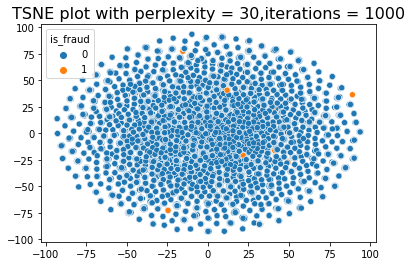

In [67]:
 # plot for tsne with perplexity = 30
ax = sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1],hue=Y_test) 
ax.set_title('TSNE plot with perplexity = 30,iterations = 1000',fontsize = 16)


## Finding the optimum perplexity with othe default parameters


CPU times: user 8h 20min 27s, sys: 5min 14s, total: 8h 25min 42s
Wall time: 5h 46min 41s


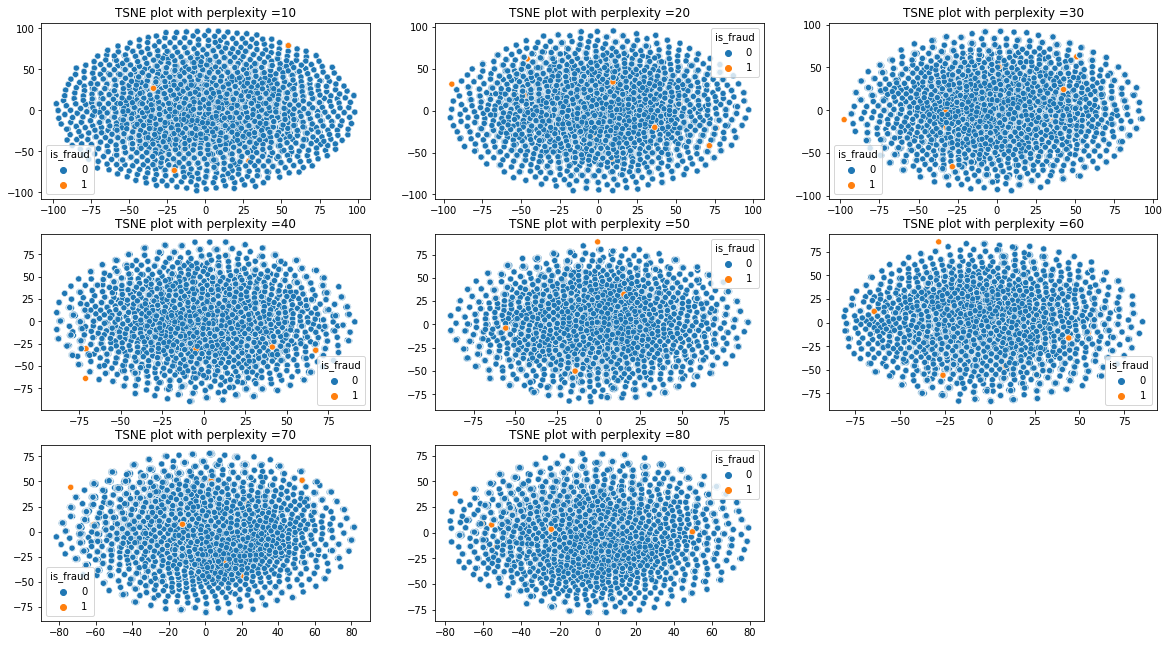

In [18]:
%%time

perp = [10,20,30,40,50,60,70,80]
fig = plt.figure(1,figsize =(20,11) )
s = int(len(perp)/3) +1
i=1
kl_div = []

for perpl in perp:
    tsne = TSNE(n_components=2, perplexity=perpl)
    tsne_results = tsne.fit_transform(df_Test)
    kl_div.append(tsne.kl_divergence_)
    #plt.subplot(s,3,i)
    
    ax = plt.subplot(s,3,i)
    ax = sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1],hue = Y_test) 
    s1 = 'TSNE plot with perplexity =' + str(perpl)
    ax.set_title(s1)
    i+=1

Text(0.5, 1.0, 'Perplexity- kl-divergence Score for tsne')

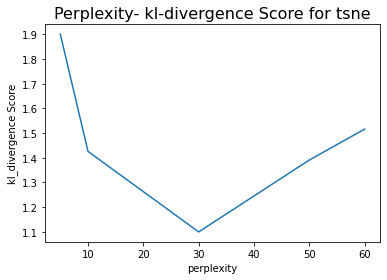

In [6]:
import matplotlib.pyplot as plt
# prep = [5,10,30,50,60]
# kl_div = [1.9,1.425989,1.1,1.391024,1.516109]
plt.plot(prep,kl_div)
plt.xlabel('perplexity')
plt.ylabel('kl_divergence Score')
plt.title("Perplexity- kl-divergence Score for tsne",fontsize = 16)

### We see that perplexity = 30 gives the minimum value for kl-divergence, so a perplexity of 30 is best for anomaly detection 


In [ ]:
# ## to save and load tsne model
# np.save('tsne.npy', x_tsne_full) 
# np.load('tsne.npy')